In [2]:
flikr_images='Flicker8k_Dataset/'
flikr_token='Flickr8k_Text/Flickr8k.token.txt'

In [3]:
import os
images=os.listdir(flikr_images)
print("The number of jpg flies in Flicker8k: {}".format(len(images)))

The number of jpg flies in Flicker8k: 8091


In [4]:
import matplotlib.pyplot as plt
import cv2

In [5]:
file=open(flikr_token,'r')
text=file.read()
file.close()

In [6]:
datatxt=[]
for line in text.split('\n'):
    col=line.split('\t')
    if len(col)==1:
        continue
    w=col[0].split("#")
    datatxt.append(w + [col[1].lower()])

In [7]:
import pandas as pd

df_txt=pd.DataFrame(datatxt,columns=['filename','index','caption'])
df_txt.shape

(40460, 3)

In [8]:

#df_txt.index[df_txt['filename']=='2258277193_586949ec62.jpg.1']
df_txt=df_txt.drop([6730, 6731, 6732, 6733, 6734])
df_txt.shape

(40455, 3)

In [9]:
import numpy as np

uni_filenames = np.unique(df_txt.filename.values)


In [10]:
import keras
from keras.preprocessing.image import  load_img,img_to_array

C:\Users\Varsha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


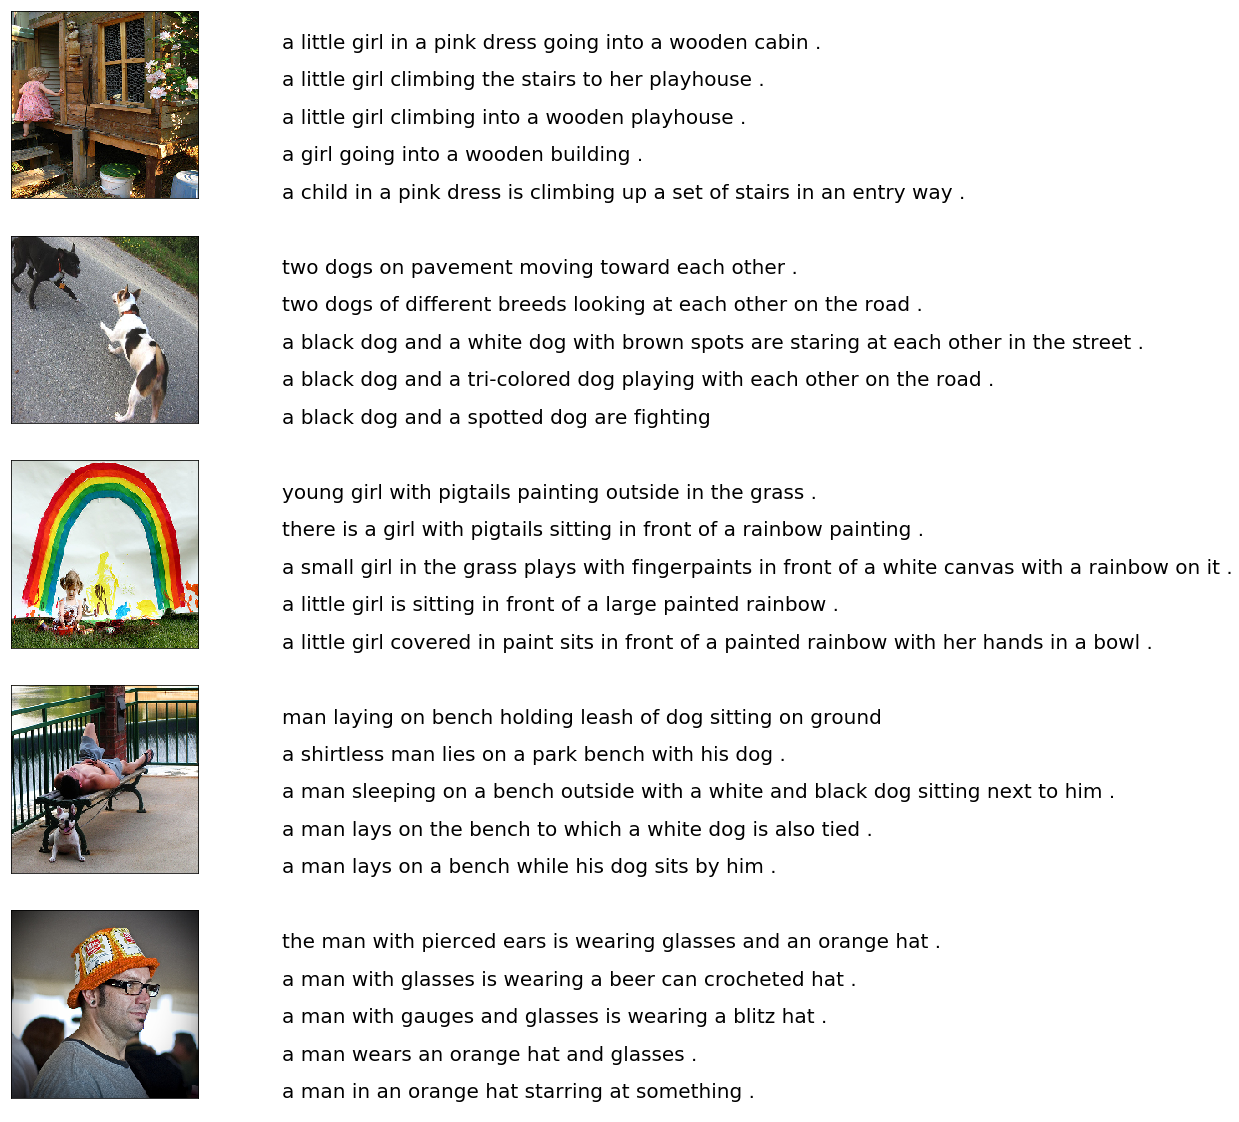

In [11]:
npic=5
npix=225
target_size=(npix,npix,3)

count=1
fig=plt.figure(figsize=(10,20))

for jpgfnm in uni_filenames[:npic]:
    filename = flikr_images  + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
    
plt.show()
    

In [12]:
from collections import Counter
import operator
import string

In [13]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    sorted_x = sorted(ct.items(), key=operator.itemgetter(1),reverse=True)
    dfword = pd.DataFrame(sorted_x,columns=['word','count'])
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)


In [14]:
dfword = df_word(df_txt)
dfword.head()

Vocabulary Size: 8918


,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743


In [15]:
def remove_punctuation(text_original):
    no_punct = ""
    for char in text_original:
           if char not in string.punctuation:
                   no_punct = no_punct + char
    return(no_punct)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


In [16]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)




In [17]:
for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

In [18]:
dfword = df_word(df_txt)

Vocabulary Size: 8763


In [19]:
from copy import copy
def add_startend_token(captions):
    caps=[]
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)


            

In [20]:
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_startend_token(df_txt["caption"])
df_txt0.reset_index(inplace=True)

In [21]:
from keras.applications import VGG16

In [22]:
model=VGG16(include_top=True,weights=None)
model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
from keras import models
model.layers.pop()
model_vg=models.Model(input=model.inputs,output=model.layers[-1].output)
model_vg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

C:\Users\Varsha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fc...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

In [25]:
import pandas as pd
flikr_df=pd.read_csv('flikr_8k.csv')

images1=OrderedDict() #which remembers the order  of keys()
npix=224
target_size=(npix,npix,3)
data=np.zeros((len(images),npix,npix,3))

In [26]:
dimages,keepindex=[],[]
df_txt0=df_txt0.loc[df_txt0["index"].values=='0',:]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in flikr_df.loc[i,'Unnamed: 0']:
        dimages.append(flikr_df.iloc[i,1:])
        keepindex.append(i)

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y_pca = pca.fit_transform(flikr_df.iloc[:,1:])

In [28]:
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [29]:
from keras.preprocessing.text import Tokenizer
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

C:\Users\Varsha\Anaconda3\lib\site-packages\keras\preprocessing\text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [30]:
dcaptions.shape,dimages.shape,len(dtexts)

((8091,), (8091, 4096), 8091)

In [31]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [32]:
len(dt_train),len(di_train),len(fnm_train)

(4855, 4855, 4855)

In [33]:
maxlen = np.max([len(text) for text in dtexts])

In [34]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [188]:
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 1618
 (16637, 30) (16637,) (16637, 4476)


In [35]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding_1[0][0]                
__________________________________________________________________________________________________
Image

import time

start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

In [39]:
model_json = model.to_json()
with open("image_captioning.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("image_captioning_weight.h5")

In [36]:
from keras.models import model_from_json
json_file = open('image_captioning.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("image_captioning_weight.h5")
print("Loaded model from disk")
 


Loaded model from disk


In [37]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

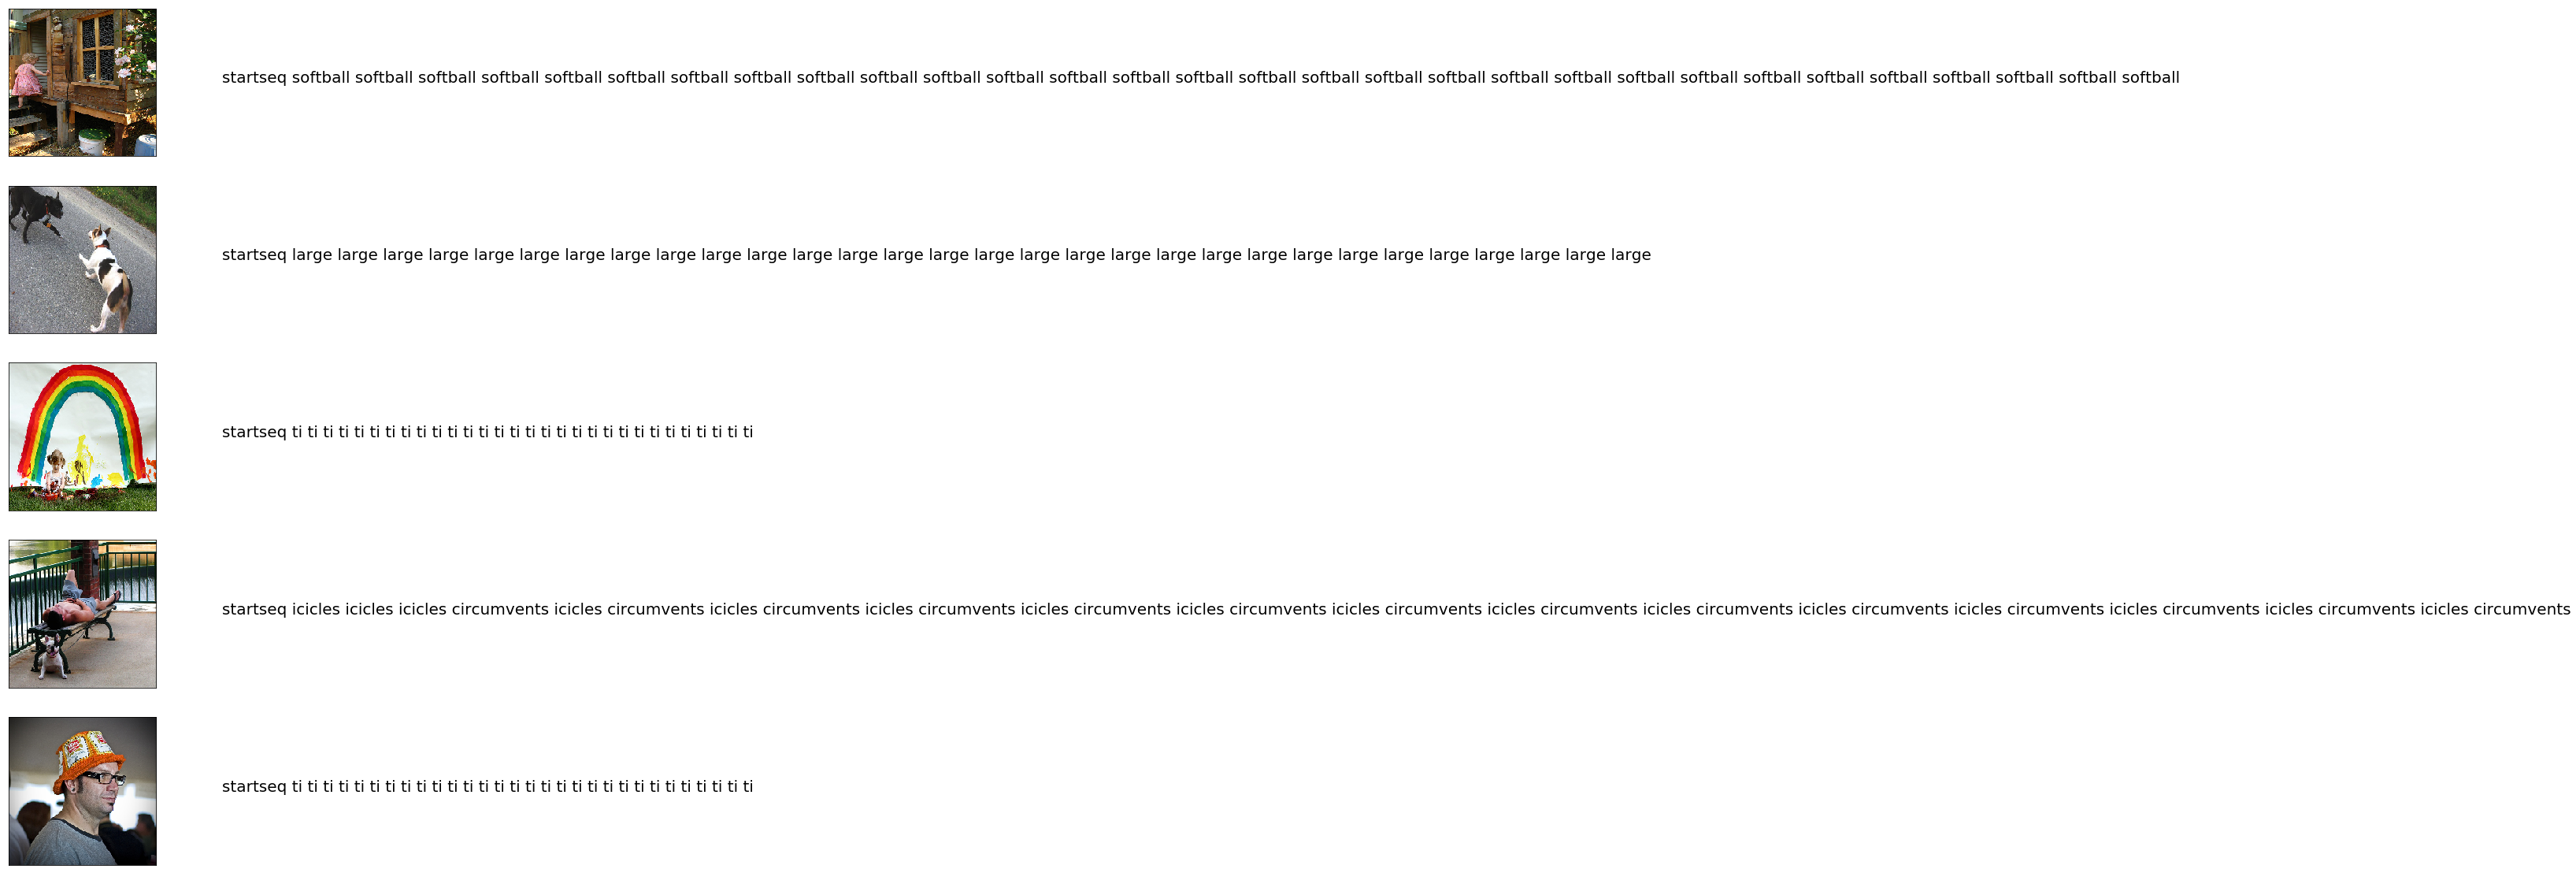

In [48]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)


npic = 5
npix = 225
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = flikr_images  + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()


In [49]:
from nltk.translate.bleu_score import sentence_bleu

In [50]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

C:\Users\Varsha\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Varsha\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Varsha\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  war

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


Bad Caption


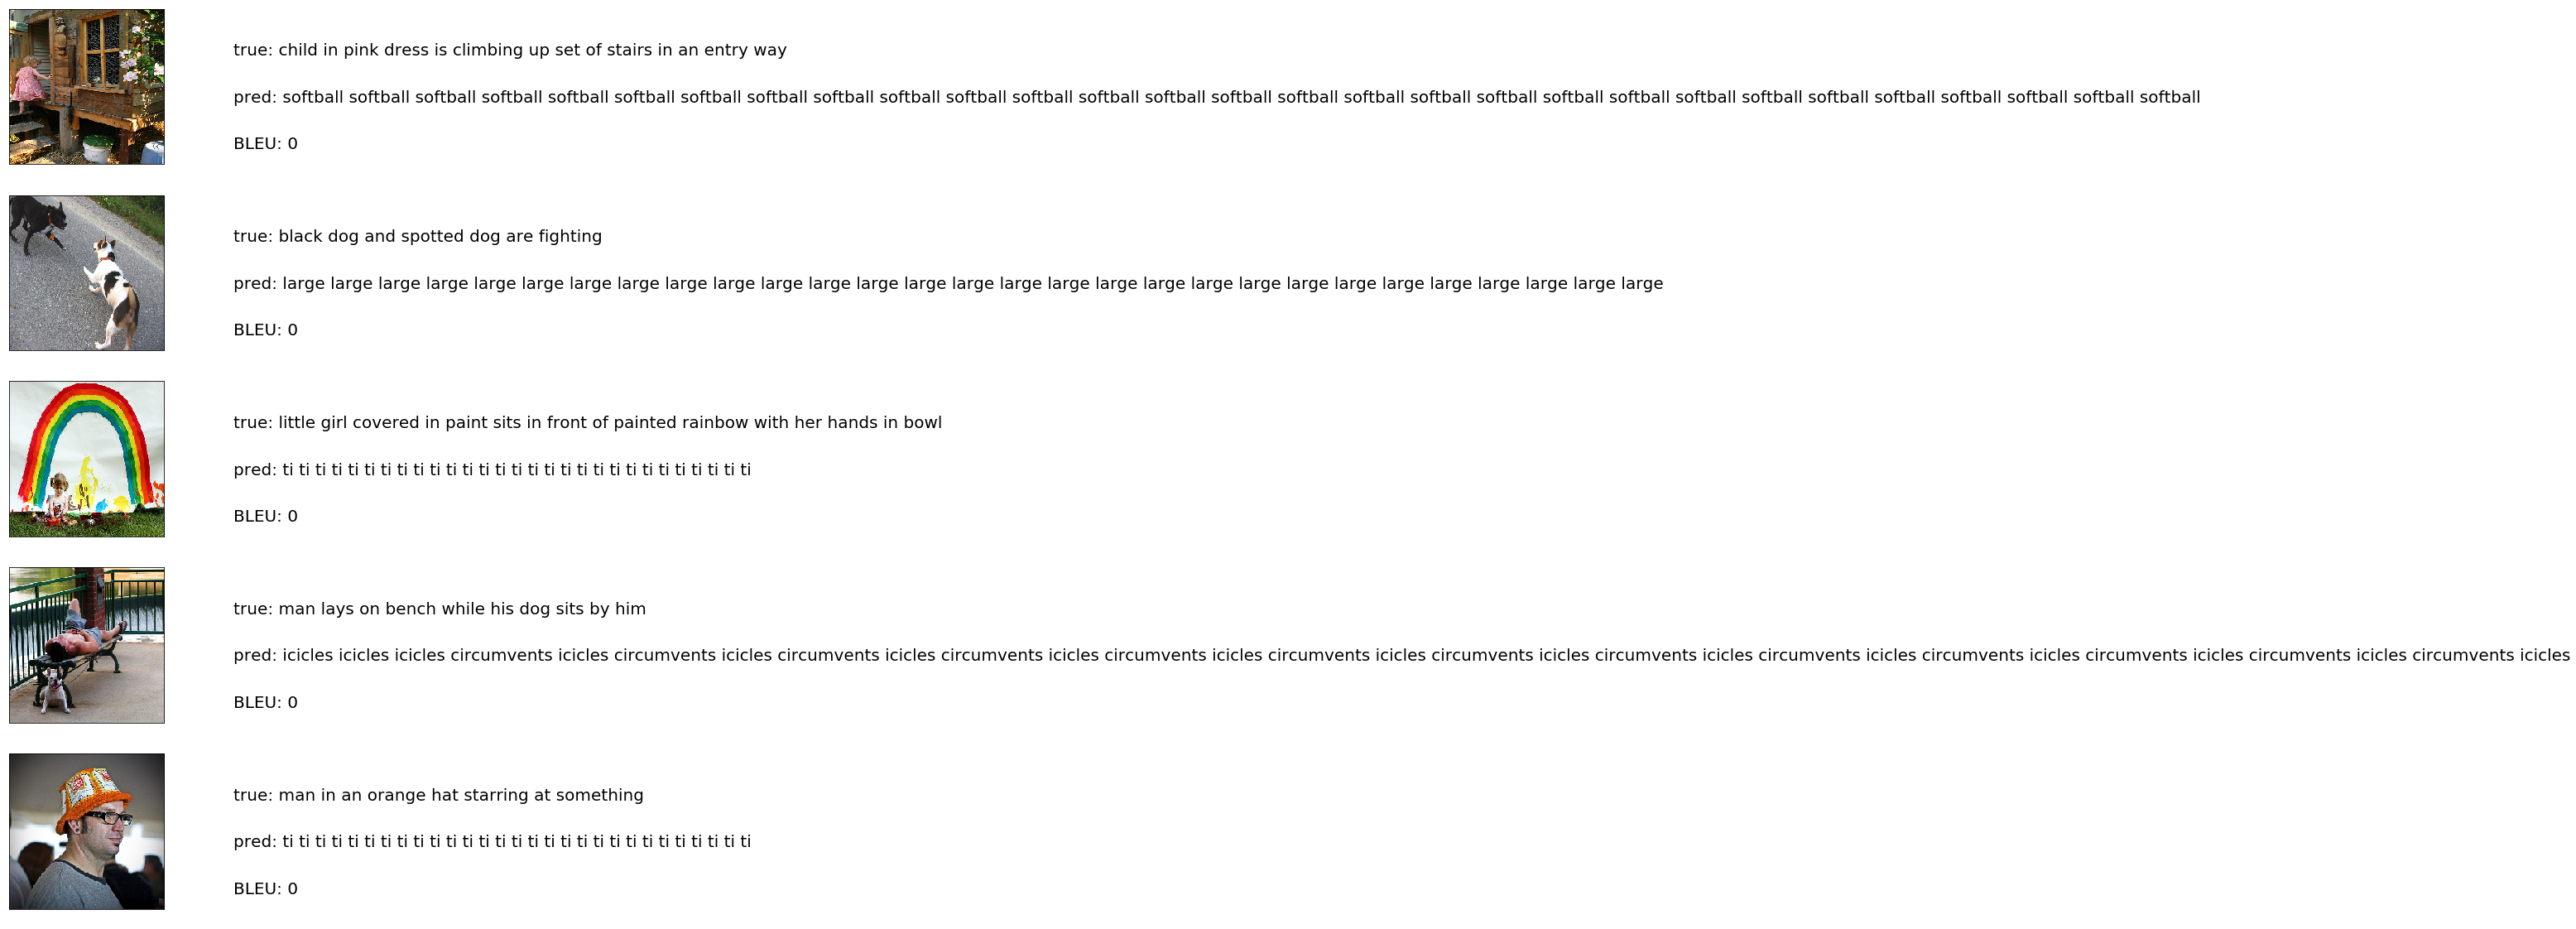

Good Caption


In [52]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = flikr_images+ jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)
 